In [ ]:
import torch
import torchvision

from diffusers import DPMSolverMultistepScheduler
from inverse_stable_diffusion import InversableStableDiffusionPipeline

from _get_noise import get_noise
from _detect import detect

from PIL import Image
import requests
from io import BytesIO

%load_ext autoreload
%autoreload 2

In [2]:
model_id = 'stabilityai/stable-diffusion-2-1-base'

# load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder='scheduler')
pipe = InversableStableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision='fp16',
    )
pipe = pipe.to(device)

Fetching 12 files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1094.14it/s]


In [ ]:
# get noise
shape = (1, 4, 64, 64)
latents, w_key, w_mask = get_noise(shape, pipe)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.30it/s]


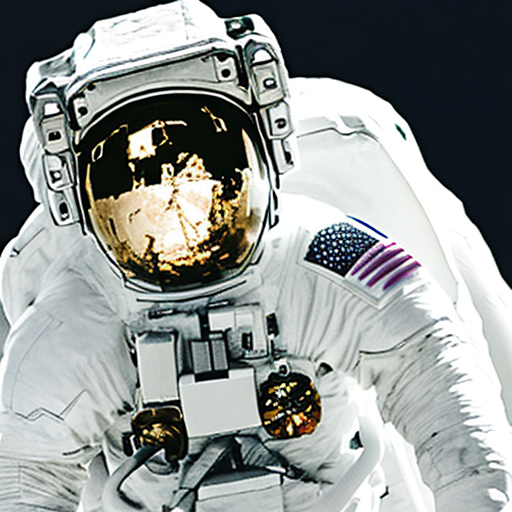

In [4]:
# generation
watermarked_image = pipe(prompt="an astronaut", latents=latents).images[0]
watermarked_image

In [5]:
is_watermarked = detect(watermarked_image, pipe, w_key, w_mask)
print(f'is_watermarked: {is_watermarked}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.38it/s]

is_watermarked: True


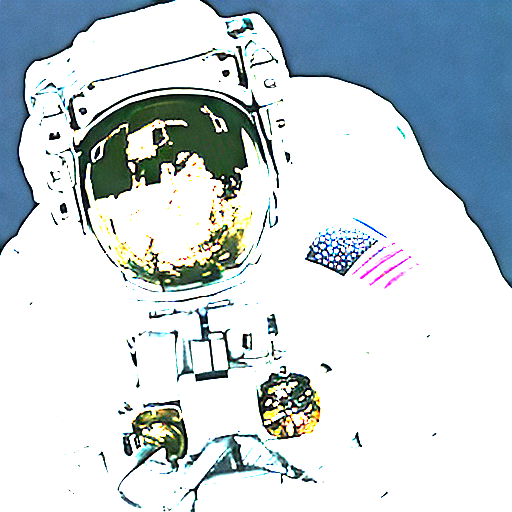

In [6]:
# color jitter
watermarked_image = torchvision.transforms.ColorJitter(brightness=[6, 6])(watermarked_image)
watermarked_image

In [7]:
is_watermarked = detect(watermarked_image, pipe, w_key, w_mask)
print(f'is_watermarked: {is_watermarked}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.56it/s]

is_watermarked: True


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.33it/s]


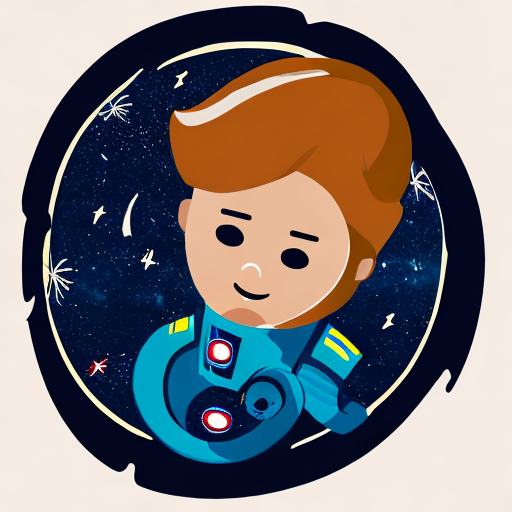

In [8]:
# generation without watermarking
unwatermarked_image = pipe(prompt="an astronaut").images[0]
unwatermarked_image

In [9]:
is_watermarked = detect(unwatermarked_image, pipe, w_key, w_mask)
print(f'is_watermarked: {is_watermarked}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.57it/s]

is_watermarked: False


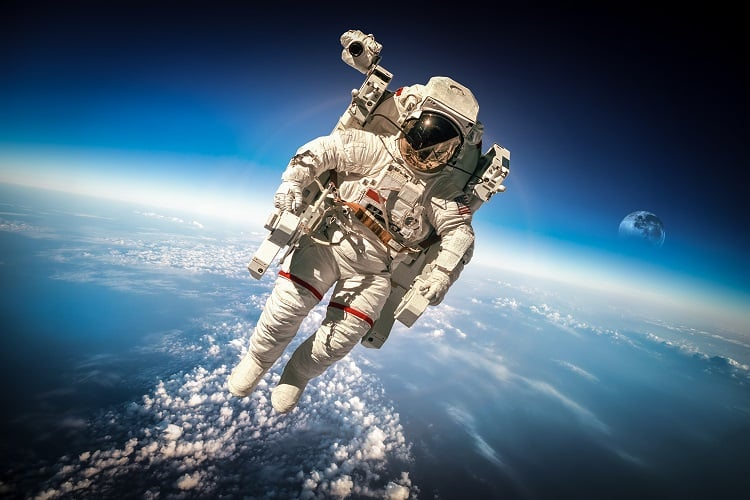

In [10]:
# unwatermarked image from internet
response = requests.get('https://www.freelancinggig.com/blog/wp-content/uploads/2016/12/how-to-become-an-astronaut.jpg')
unwatermarked_image = Image.open(BytesIO(response.content))
unwatermarked_image

In [11]:
is_watermarked = detect(unwatermarked_image, pipe, w_key, w_mask)
print(f'is_watermarked: {is_watermarked}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.53it/s]

is_watermarked: False
